In [37]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
customers=pd.read_csv('customer_churn.csv')
customers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
customers = customers[['SeniorCitizen','tenure','MonthlyCharges','Churn']]
customers

,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,29.85,No
1,0,34,56.95,No
2,0,2,53.85,Yes
3,0,45,42.30,No
4,0,2,70.70,Yes
...,...,...,...,...
7038,0,24,84.80,No
7039,0,72,103.20,No
7040,0,11,29.60,No
7041,1,4,74.40,Yes


In [40]:
#there are no NaN values so we don't have to change anything to the data at this point
customers.isna().sum()

SeniorCitizen     0
tenure            0
MonthlyCharges    0
Churn             0
dtype: int64

In [41]:
cols = []
for c in customers.columns:
    cols.append(c.lower())
customers.columns = cols

In [42]:
def transform_churn(x):
    if x == 'Yes':
        return 1
    else:
        return 0

customers['churn'] = list(map(transform_churn,customers['churn']))
customers.head()

,seniorcitizen,tenure,monthlycharges,churn
0,0,1,29.85,0
1,0,34,56.95,0
2,0,2,53.85,1
3,0,45,42.30,0
4,0,2,70.70,1


In [43]:
X = customers.drop(['churn'], axis=1)
y = customers['churn']

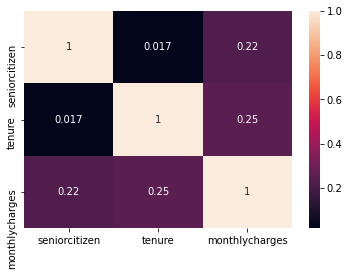

In [44]:
#there is no high multicolinearity so we don't have to drop any columns
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

<AxesSubplot:>

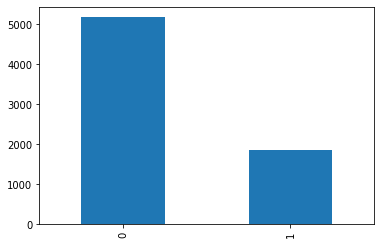

In [45]:
#checking for imbalance, there are a lot more No's then Yesses.
balance_target = pd.value_counts(customers['churn'])
balance_target.plot(kind = 'bar')

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X_train)
X_std_train = transformer.transform(X_train)
X_std_train = pd.DataFrame(X_std_train,columns=X.columns)

X_std_test = transformer.transform(X_test)
X_std_test = pd.DataFrame(X_std_test,columns=X.columns)

In [48]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state =0, solver='lbfgs').fit(X_std_train,y_train)
classification.score(X_std_test, y_test)

#with a simple model we get a high accuracy score of .79. 
#However as the barplot in cell 45 shows there is a very big imbalance between Yes and No churns. There are more than double No's than Yesses.
#this explains the high score because by simply guessing No the model will get still a of values right, but the impact of the error is bigger.

0.7936583057264552

In [49]:
#The precision, recall and F1 score show this imbalance better in scores. The score lowered to 0.44 for recall, showing it's not a very good model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predictions = classification.predict(X_std_test)

print("precision: ",precision_score(y_test,predictions))
print("recall: ",recall_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions))

precision:  0.6835106382978723
recall:  0.44773519163763065
f1:  0.5410526315789473


In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[1420,  119],
       [ 317,  257]])

In [53]:
#To try and improve the model we are going to use the SMOTE method to lose the imbalance in the data and try to get a higher score
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_std_train,y_train)

In [58]:
class_smote = LogisticRegression(random_state=0,solver='lbfgs').fit(X_train_SMOTE,y_train_SMOTE)
class_smote.score(X_std_test, y_test)

0.7411263606247042

In [57]:
pred_smote = class_smote.predict(X_std_test)

print("precision: ",precision_score(y_test,pred_smote))
print("recall: ",recall_score(y_test,pred_smote))
print("f1: ",f1_score(y_test,pred_smote))

precision:  0.5161676646706587
recall:  0.7508710801393729
f1:  0.6117814052519518


In [62]:
pred_smote

array([0, 0, 0, ..., 0, 1, 0])

In [61]:
confusion_matrix(y_test,pred_smote)

array([[1135,  404],
       [ 143,  431]])

In [63]:
431/(431+143)

0.7508710801393729

In [ ]:
#The SMOTE improved the model, the accuracy, but the confusion matrix show more balanced predictions
recall went up
